# Facade instance segmentation

We will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model. This code is inspired on TorchVision Instance Segmentation Finetuning Tutorial (https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-3hsr9bnn
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-3hsr9bnn
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp311-cp311-linux_x86_64.whl size=395984 sha256=25194cb6a2f7114d6a355977725c9c107caf6915f83e1a3c547f03747ea1ca1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-korcqa9u/wheels/6d/69/75/358c50a37672dfda8d74ba3b30ec49fb75d52f7c081886d503
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.8
    Uninstalling pycocotools-2.0.8:
      Successfully uninstalled pycocotools-2.0.8


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for CMP dataset

Let's write a facade dataset, based on:
https://cmp.felk.cvut.cz/~tylecr1/facade/

In [ ]:
#%%shell

# access the adjusted CMP dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/CMP_Facade_base_changed_doors"

Mounted at /content/drive


In [ ]:
##enforce the compatible torch version
!pip install torch===1.13.1 torchvision===0.14.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision===0.14.1 (from versions: 0.1.6, 0.2.0, 0.15.0+cpu, 0.15.0+cu117, 0.15.0+cu118, 0.15.1, 0.15.1+cpu, 0.15.1+cu117, 0.15.1+cu118, 0.15.2, 0.15.2+cpu, 0.15.2+cu117, 0.15.2+cu118, 0.15.2+rocm5.3, 0.15.2+rocm5.4.2, 0.16.0, 0.16.0+cpu, 0.16.0+cu118, 0.16.0+cu121, 0.16.0+rocm5.5, 0.16.0+rocm5.6, 0.16.1, 0.16.1+cpu, 0.16.1+cu118, 0.16.1+cu121, 0.16.1+rocm5.5, 0.16.1+rocm5.6, 0.16.2, 0.16.2+cpu, 0.16.2+cu118, 0.16.2+cu121, 0.16.2+rocm5.5, 0.16.2+rocm5.6, 0.17.0, 0.17.0+cpu, 0.17.0+cu118, 0.17.0+cu121, 0.17.0+rocm5.6, 0.17.0+rocm5.7, 0.17.1, 0.17.1+cpu, 0.17.1+cu118, 0.17.1+cu121, 0.17.1+rocm5.6, 0.17.1+rocm5.7, 0.17.2, 0.17.2+cpu, 0.17.2+cu118, 0.17.2+cu121, 0.17.2+rocm5.6, 0.17.2+rocm5.7, 0.18.0, 0.18.0+cpu, 0.18.0+cu118, 0.18.

Let's open an image to check whether it works!

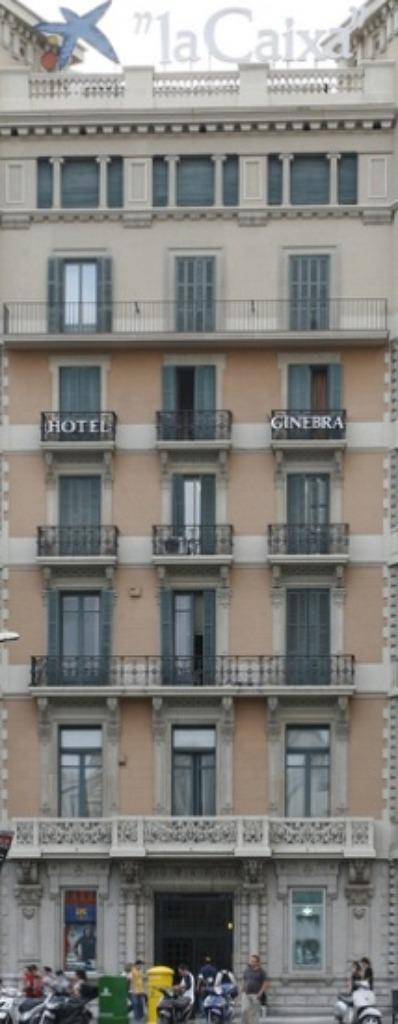

In [ ]:
from PIL import Image

##Check whether there's an access to your Google Drive by showing one of the training photos
imgPath = path + "/images/cmp_b0002.jpg"
Image.open(imgPath)

Let's open a respective mask to check whether it works!

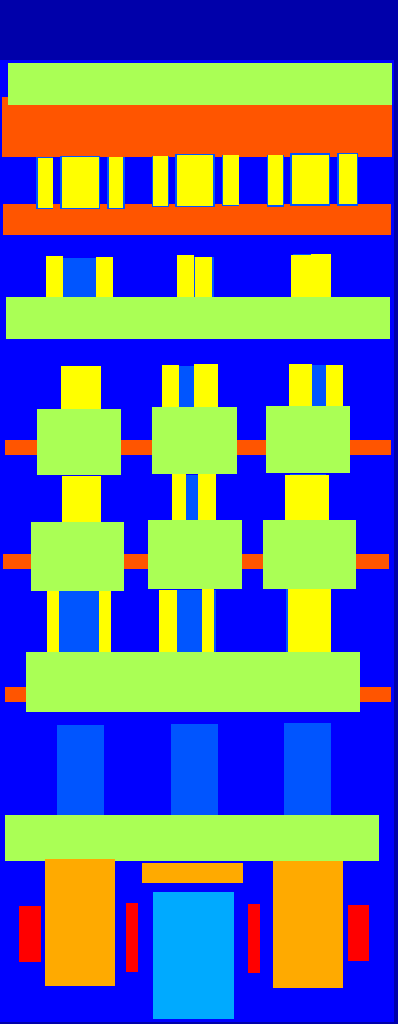

In [ ]:
import numpy as np
from skimage.measure import label, regionprops

maskPath = path + "/masks/cmp_b0002.png"
mask = Image.open(maskPath)

# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.

'''
labels:

1. background
2. facade
3. window
4. door
5. cornice
6. sill
7. balcony
8. blind
9. deco
10. molding
11. pillar
12. shop
'''

mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from skimage.measure import label, regionprops


class CMPdata(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        #take only class 3 (window) or class 8 (blind) [in case doors are needed, add it]
        #and assign zero to the rest
        #desired_classes = np.where(np.logical_or(mask == 3, mask == 4), mask, mask * 0)
        desired_classes = np.where(mask == 4, mask, mask * 0)

        #assign distinct, consecutive labels to regions
        label_image = label(desired_classes, background=0)

        # instances are encoded as different colors
        obj_ids = np.unique(label_image)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        #blobed features to be parsed as mask-instances
        masks = label_image == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
          pos = np.where(masks[i])
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])
          if xmin != xmax and ymin != ymax:
            boxes.append([xmin, ymin, xmax, ymax])
          else:
            print("bounding box has an invalid size and will be skipped")

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class -> we merge windows with blinds
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = CMPdata(path)
dataset[0]

(<PIL.Image.Image image mode=RGB size=543x1024>,
 {'boxes': tensor([[ 346.,  887.,  412.,  996.],
          [ 245.,  888.,  311.,  997.],
          [ 142.,  890.,  208., 1000.],
          [ 466.,  942.,  504.,  996.],
          [  42.,  953.,   82., 1013.]]),
  'labels': tensor([1, 1, 1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
         

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 618409, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 618409 (delta 62), reused 38 (delta 37), pack-reused 618319 (from 3)
Receiving objects: 100% (618409/618409), 1.15 GiB | 34.07 MiB/s, done.
Resolving deltas: 100% (578374/578374), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
%%shell

#Remove the lines that import torch._six
sed -i '/import torch._six/d' /content/coco_eval.py /content/utils.py /content/transforms.py /content/engine.py /content/coco_utils.py

#Replace any usage of torch._six with a standard alternative, e.g. the built-in 'six' or just remove
sed -i 's/torch._six/six/g' /content/coco_eval.py /content/utils.py /content/transforms.py /content/engine.py /content/coco_utils.py


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)



#### Testing forward() method

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = CMPdata(path, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 166MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker proc

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = CMPdata(path, get_transform(train=True))
dataset_test = CMPdata(path, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 170MB/s]


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# Code to make it run!!

In [ ]:
!pip install six

In [ ]:
%%writefile /content/coco_eval.py.new
import copy
import io
from contextlib import redirect_stdout
import numpy as np
import pycocotools.mask as mask_util
import torch
import six  # Add this import
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Copy the rest of the content from the original file
with open('/content/coco_eval.py', 'r') as f:
    content = f.read()
    # Skip the first few lines, which likely include imports
    content = '\n'.join(content.split('\n')[6:])

print(content)

Overwriting /content/coco_eval.py.new


In [ ]:
!mv /content/coco_eval.py.new /content/coco_eval.py

In [ ]:
!sed -i 's/six.string_classes/six.string_types/g' /content/coco_eval.py

In [ ]:
class FacadeDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # Take only class 3 (window) or class 8 (blind)
        desired_classes = np.where(mask == 4, mask, mask * 0)

        # Assign distinct, consecutive labels to regions
        label_image = label(desired_classes, background=0)

        # Get unique instance ids
        obj_ids = np.unique(label_image)
        obj_ids = obj_ids[1:]  # First id is background, so remove it

        # Create binary masks
        masks = label_image == obj_ids[:, None, None]

        # Get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            if len(pos[0]) > 0:  # Check if mask is not empty
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                if xmin != xmax and ymin != ymax:
                    boxes.append([xmin, ymin, xmax, ymax])
                # Removed the warning print here

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class -> we merge windows with blinds
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        masks = torch.as_tensor(masks[:len(boxes)], dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            # Convert outputs to CPU for inspection if needed
            # outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]

    print("Evaluation complete")
    return None

In [ ]:
# Train for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Update the learning rate
    lr_scheduler.step()
    # Run simplified evaluation
    print("Evaluating model...")
    evaluate(model, data_loader_test, device=device)

    # Save model checkpoint
    print(f"Saving model checkpoint for epoch {epoch}")
    torch.save(model.state_dict(), f'facade_model_epoch_{epoch}.pth')

Epoch: [0]  [ 0/92]  eta: 0:06:54  lr: 0.000060  loss: 3.0383 (3.0383)  loss_classifier: 0.6085 (0.6085)  loss_box_reg: 0.0402 (0.0402)  loss_mask: 2.1079 (2.1079)  loss_objectness: 0.2645 (0.2645)  loss_rpn_box_reg: 0.0171 (0.0171)  time: 4.5000  data: 1.2513  max mem: 2169
Epoch: [0]  [10/92]  eta: 0:01:17  lr: 0.000609  loss: 1.6533 (1.9604)  loss_classifier: 0.3522 (0.3776)  loss_box_reg: 0.0589 (0.0626)  loss_mask: 1.1568 (1.3160)  loss_objectness: 0.1996 (0.1906)  loss_rpn_box_reg: 0.0138 (0.0136)  time: 0.9409  data: 0.1294  max mem: 3237
Epoch: [0]  [20/92]  eta: 0:00:56  lr: 0.001158  loss: 1.2806 (1.4810)  loss_classifier: 0.1789 (0.2694)  loss_box_reg: 0.0828 (0.0782)  loss_mask: 0.8565 (0.9944)  loss_objectness: 0.0740 (0.1282)  loss_rpn_box_reg: 0.0078 (0.0108)  time: 0.6038  data: 0.0155  max mem: 3974
Epoch: [0]  [30/92]  eta: 0:00:46  lr: 0.001707  loss: 0.8471 (1.2500)  loss_classifier: 0.1336 (0.2330)  loss_box_reg: 0.0963 (0.0936)  loss_mask: 0.4478 (0.8134)  loss_ob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
#use this snippet in case you want to save your weights and re-use them
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

checkpoint = torch.load("/content/drive/MyDrive/Trained Models mask 4 class 2/facade_model_epoch_9.pth")

# Falls du nur die Gewichte laden möchtest, benutze:
model.load_state_dict(checkpoint)
model.to(device)

#model = torch.load("/content/drive/MyDrive/Trained Models/facade_model_epoch_9.pth")

#and this one, in case of a GPU/CPU clash use this snippet:
#model = torch.load("/content/drive/MyDrive/Facade_instance_segmentation/CMP_Facade_base_changed/weights/model.pth", map_location=torch.device('cpu'))

# pick one image from the test set
img, _ = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

[{'boxes': tensor([[449.8166, 590.5634, 551.0085, 700.7565],
          [  9.8930, 579.3796, 116.3381, 697.1121],
          [275.0572, 580.3095, 358.1001, 714.1564],
          [433.0134, 581.3358, 619.7798, 707.8749],
          [575.0006, 590.1722, 607.6973, 687.6649],
          [550.9908, 583.9890, 609.8428, 698.3185],
          [182.2982, 582.8571, 270.2811, 687.4199],
          [360.2767, 595.6857, 416.5715, 712.6495]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.7886, 0.7768, 0.6121, 0.2192, 0.1177, 0.1117, 0.0795, 0.0708],
         device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

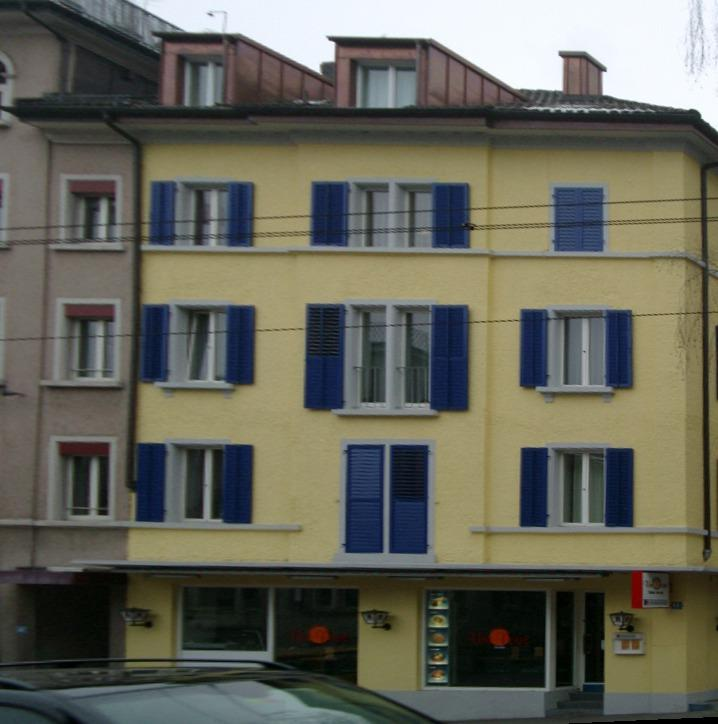

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

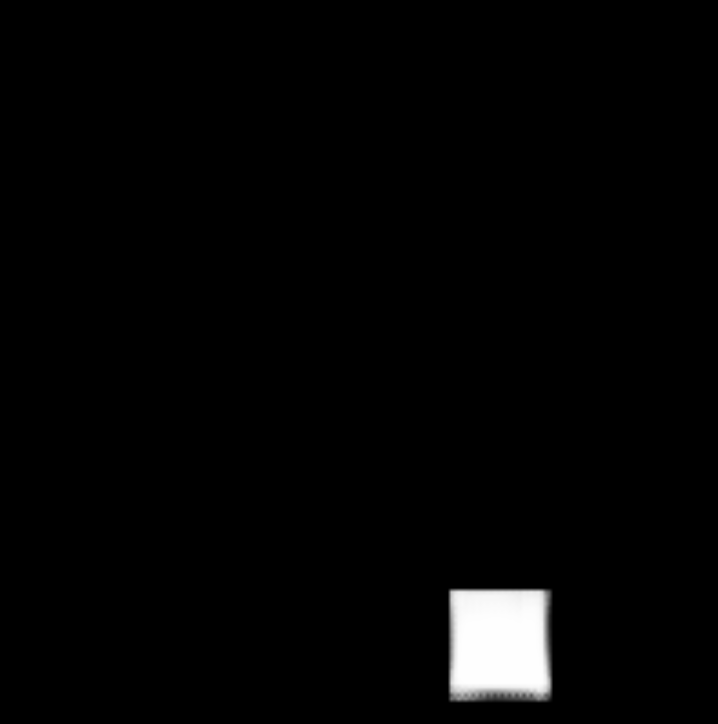

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
print(prediction[1])

IndexError: list index out of range

Now, let's check the performance on the TUM-FACADE

In [ ]:
print(path)

/content/drive/MyDrive/Colab Notebooks/CMP_Facade_base_changed


In [ ]:
# load the images from the prediction set
from PIL import Image
import torchvision.transforms as transforms
import torch
import torchvision.models as models

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#model = torch.load("/content/drive/MyDrive/Trained Models/facade_model_epoch_9.pth")
num_classes = 2
# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
checkpoint = torch.load("/content/drive/MyDrive/Trained Models/facade_model_epoch_9.pth")
#checkpoint = torch.load("/content/drive/MyDrive/Trained Models/Frmodel_altesTraining.pth")
# Falls du nur die Gewichte laden möchtest, benutze:
model.load_state_dict(checkpoint)
model.to(device)

#predictionPath = path + "/prediction/wallAver5.jpg"
predictionPath = "/content/drive/MyDrive/Data_shared/facade_instance_segmentation/DEBY_LOD2_4959323_3.png"
predImg = Image.open(predictionPath).convert("RGB")


# Define a transform to convert PIL
# image to a Torch tensor
transform = transforms.Compose([transforms.ToTensor()])

# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = transform(predImg)

# print the converted Torch tensor,  print(img_tensor)

model.eval()
with torch.no_grad():
    prediction = model([img_tensor.to(device)])





In [ ]:
prediction

[{'boxes': tensor([[186.3727, 233.5979, 229.6367, 315.0311],
          [398.6732, 236.3535, 441.8737, 313.6317],
          [ 78.2705, 234.3260, 122.1959, 314.2952],
          [293.1172, 237.5373, 335.1406, 313.7733],
          [ 73.9063, 381.4908, 122.1949, 455.0934],
          [ 82.1424, 104.5512, 127.7429, 168.0211],
          [188.4990, 105.5462, 233.7713, 168.1832],
          [295.8993, 108.2297, 336.6393, 168.2532],
          [401.6969, 377.5805, 445.9866, 454.9392],
          [399.7490, 109.2830, 441.4168, 168.9494],
          [303.6024,  46.8000, 334.3455,  64.4944],
          [407.9234,  47.3286, 438.0698,  64.7340],
          [198.6898,  45.5061, 229.0966,  63.8472],
          [ 91.4033,  45.7341, 122.0961,  62.2248],
          [223.8255, 424.3136, 285.8374, 521.6831],
          [ 80.1172, 502.9456, 125.0000, 525.0767],
          [223.1060, 366.9890, 299.2800, 468.9543],
          [418.2755, 112.0654, 437.6468, 167.3642],
          [226.7677, 369.9922, 288.0377, 402.3479]], de

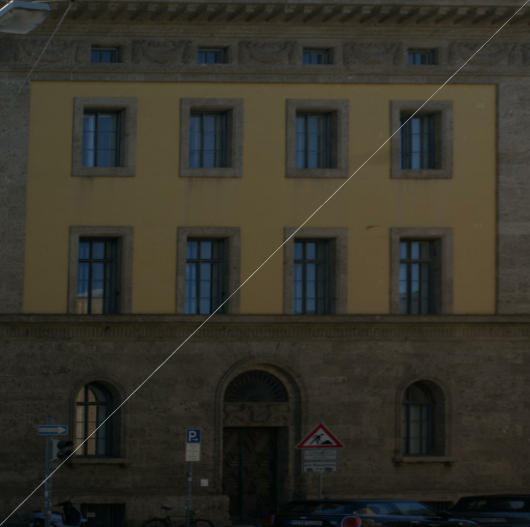

In [ ]:
Image.fromarray(img_tensor.mul(255).permute(1, 2, 0).byte().numpy())

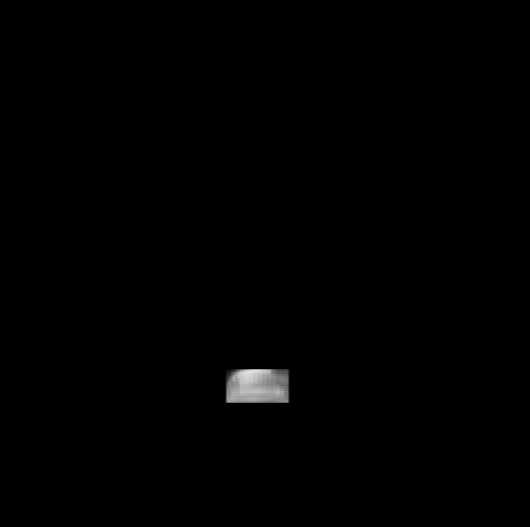

In [ ]:
Image.fromarray(prediction[0]['masks'][18, 0].mul(255).byte().cpu().numpy())

Let's save the tensor representing all instances into one image

In [ ]:
from torchvision.utils import save_image

selected_photo = prediction[0]
selected_masks = selected_photo['masks']

#squeeze extra dimension given to the masks
selected_masks = torch.squeeze(selected_masks, 1)

#test = selected_masks[1] #first element of the tensor = first instance mask
num_of_masks = selected_masks.size(dim=0)
x_of_masks = selected_masks.size(dim=1)
y_of_masks = selected_masks.size(dim=2)

list_of_arrays = []
final_mask = selected_masks.sum(axis=0)
for i in range(num_of_masks):
  np_arr = selected_masks[i].cpu().detach().numpy()
  list_of_arrays.append(np_arr)

one_composite_mask = sum(list_of_arrays)

# save_path = path + "/results/wallBmaskFull.jpg"
# save_image(selected_masks, save_path)

#saveMask = Image.fromarray(prediction[0]['masks'][5, 0].mul(255).byte().cpu().numpy())
save_mask = Image.fromarray(final_mask.mul(255).byte().cpu().numpy())
#save_mask = save_mask.convert("L")
save_mask = save_mask.save("/content/drive/MyDrive/Data_shared/facade_instance_segmentation/class_3_4/predictions/DEBY_LOD2_4959323_3.jpg")